In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import sys
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from tokenizerManager import TokenizerManager
from data.utils_bbc import get_dataloaders as get_dataloaders_bbc

In [2]:
LOADDATASIZE = 500  # row of data
BATCH_SIZE = 8  # batch size
PAD_TOKEN_ID = 0

### check GPU avaiabel

In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# load the dataset
df = pd.read_parquet('../data/NewsSummary.parquet')
# select the first 500 rows of the dataset
df = df.iloc[:500, :]
# select two columns
df = df[['ctext', 'text']]   # original text and summary
data = df.copy()
data.head()

,ctext,text
0,India will host its first WTA tournament in fi...,India will host its first WTA tournament in fi...
1,"Samajwadi Party vice-president Kiranmay Nanda,...","Ousted SP Vice President Kiranmoy Nanda, who w..."
2,"Gurgaon, Jul 7 (PTI) Gurgaon Police today regi...",Servers of a Gurugram-based clothing company h...
3,Cash-strapped holidaymakers are making their t...,Passengers are making their toddlers drag suit...
4,"London, Jun 30 (PTI) Supermodel Gigi Hadid say...",Model Gigi Hadid has said she cannot pull off ...


In [5]:
TOKENIZER_MANAGER = TokenizerManager(num_words=10000)
# TOKENIZER_MANAGER.train_tokenizer_from_csv("../data/bbc-news-summary.csv")
# TOKENIZER_MANAGER.save_tokenizer("../data/tokenizer_fixed.pkl")

TOKENIZER = TOKENIZER_MANAGER.load_tokenizer(load_path="../data/tokenizer_fixed.pkl")
print("tokenizer done, with length", len(TOKENIZER.word_index) + 1)
print("vocab size:", TOKENIZER.num_words)


tokenizer done, with length 34994
vocab size: 10000


In [8]:
# load data for training and validation, size is LOADDATASIZE
train_loader, val_loader = get_dataloaders_bbc("../data/bbc-news-summary.csv", TOKENIZER, LOADDATASIZE, BATCH_SIZE)


Index(['File_path', 'Articles', 'Summaries'], dtype='object')


In [7]:
import torch
from model.LSTM_seq2seq import Encoder, Decoder, Seq2Seq, Attention

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = TOKENIZER.num_words + 1
OUTPUT_DIM = TOKENIZER.num_words + 1
EMB_DIM = 256  # embedding dimension for both encoder and decoder
HID_DIM = 512  # hidden dimension for LSTM
N_LAYERS = 2

# 1. Attention
attn = Attention(enc_hid_dim=HID_DIM, dec_hid_dim=HID_DIM)

# 2. Encoder 和 Decoder（Decoder 加入 attn）
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS) 
dec = Decoder(OUTPUT_DIM, EMB_DIM, enc_hid_dim=HID_DIM, dec_hid_dim=HID_DIM,
            attention=attn, num_layers=N_LAYERS)

# 3. Seq2Seq
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

In [ ]:
import torch.nn as nn
from tqdm import tqdm

train_loss_history = []
val_loss_history = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 是 padding id
  # use cross entropy loss for seq2seq model

LOSS_THRESHOLD= 0.06  # loss threshold for early stopping

for epoch in range(300):
    # ✅ Training
    model.train()
    total_train_loss = 0
    for src, trg in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # ✅ Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_train_loss < LOSS_THRESHOLD:
        print(f'Early stop at epoch {epoch}: Loss is below the threshold {avg_train_loss:.4f}.')
        break

In [9]:
# save the model
os.makedirs("checkpoint", exist_ok=True)
torch.save(model.state_dict(), "checkpoint/seq2seq_bbc_1500_fixed.pt")
print("✅ model is trained and saved successfully。")


✅ model is trained and saved successfully。


✅ Loss curve diagram is saved successfully


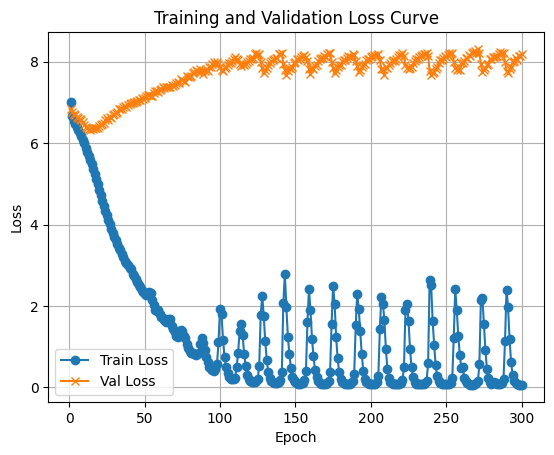

In [10]:
import matplotlib.pyplot as plt

# ✅ 绘图：训练集 & 验证集 Loss 曲线
print("==============================")
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label='Train Loss', marker='o')
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label='Val Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("checkpoint/loss_curve_bbc_1500_fixed.png")
# plt.show()
print("✅ Loss curve diagram is saved successfully")